In [1]:
import chess.pgn
import numpy as np

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,AnnotationBbox)
from matplotlib.cbook import get_sample_data
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

In [2]:
def get_eval_clock(comment, verbose=0):
    if ('eval' in next_node.comment) and ('clk' in next_node.comment):
        half_split = comment.split('eval ')[1].split('] [')
        if '#' in half_split[0]:
            evaluation = 100/float(half_split[0].split('#')[1])
            if verbose > 0:
                print('For {}, eval = {}'.format(half_split[0],evaluation))
        else:
            evaluation = float(half_split[0])
        clock = half_split[1].split('clk ')[1].split(']')[0]
        clock_seconds = sum(x * int(t) for x, t in zip([3600, 60, 1], clock.split(":"))) 
        return (evaluation, clock_seconds)
    else:
        return (np.NaN, np.NaN)

def smooth_signal(signal, N):
    """
    Simple smoothing by convolving a filter with 1/N.
    """
    # 1.) Prepare edges
    signal = np.concatenate([signal[0:N], signal, signal[-N:]])
    # 2.) Convolve
    signal = np.convolve(signal, np.ones((N,))/N, mode='same')
    # 3.) Cut edges
    signal = signal[N:-N]

    return signal

In [3]:
pgn_data = open("/home/marx/Downloads/lichess_DrNykterstein_2020-04-02_withclockandeval.pgn")
all_games, ii = [], 0
while True:
    print('{}'.format(ii), end='\r')
    chess_game = chess.pgn.read_game(pgn_data)
    if chess_game is None:
        break  # end of file
    if ((chess_game.headers['UTCDate'] != '2020.04.01') and (chess_game.headers['UTCDate'] != '2020.04.02')) or (chess_game.headers['TimeControl'] != '60+0'):
        continue
    this_chess_game = chess_game
    clock_times, evaluations, boards = [], [], []
    while not chess_game.is_end():
        board = chess_game.board()
        next_node = chess_game.variation(0)
        chess_game = next_node
        evaluation, clock_seconds = get_eval_clock(next_node.comment)
        clock_times.append(clock_seconds)
        boards.append(board)
        evaluations.append(evaluation)
    evaluations = np.array(evaluations)
    clock_times = np.array(clock_times)    
        
    all_games.append((this_chess_game, boards, evaluations, clock_times))
    ii += 1
#plt.fill_between(x, smooth_avg - smooth_std, smooth_avg + smooth_std, alpha=0.2, color='r')

In [4]:
evaluation_matrix = np.ones((len(all_games), 200))*np.NaN
clock_matrix_carlsen = np.ones((len(all_games), 100))*np.NaN
clock_matrix_alireza = np.ones((len(all_games), 100))*np.NaN
results, results_color = [], []
for idx, (chess_game, boards, evaluations, clock_times) in enumerate(all_games):
    evaluation_matrix[idx, 0:len(evaluations)] = evaluations
    #print(chess_game.headers)
    if chess_game.headers['Result'] == '1/2-1/2':
        result = 'draw'
        result_color = 'draw'
    elif chess_game.headers['Result'] == '1-0':
        result = chess_game.headers['White']
        result_color = 'white'
    elif chess_game.headers['Result'] == '0-1':
        result = chess_game.headers['Black']
        result_color = 'black'
    # clock times
    white_clock_times = clock_times[0::2]
    black_clock_times = clock_times[1::2]
    if chess_game.headers['White'] == 'DrNykterstein':
        clock_matrix_carlsen[idx, 0:len(white_clock_times)] = white_clock_times
        clock_matrix_alireza[idx, 0:len(black_clock_times)] = black_clock_times
    elif chess_game.headers['White'] == 'alireza2003':
        clock_matrix_carlsen[idx, 0:len(black_clock_times)] = black_clock_times
        clock_matrix_alireza[idx, 0:len(white_clock_times)] = white_clock_times
    results.append(result)
    results_color.append(result_color)
results = np.array(results)
results_color = np.array(results_color)
# Cut at +-10 eval
evaluation_matrix[evaluation_matrix < -10] = -10
evaluation_matrix[evaluation_matrix > 10] = 10
# Cut at 160 moves
evaluation_matrix = evaluation_matrix[:, 0:140]

/home/marx/.conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
/home/marx/.conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


---
# Plot all games

In [5]:
#evaluation_matrix_cut = evaluation_matrix[:, 0:15]
#outliers = np.where(np.any(abs(evaluation_matrix_cut) > 3, axis=1))
#chess.svg.board(all_games[55][1][11], arrows=[chess.svg.Arrow(chess.F1, chess.A6)], size=1000)

<IPython.core.display.Javascript object>


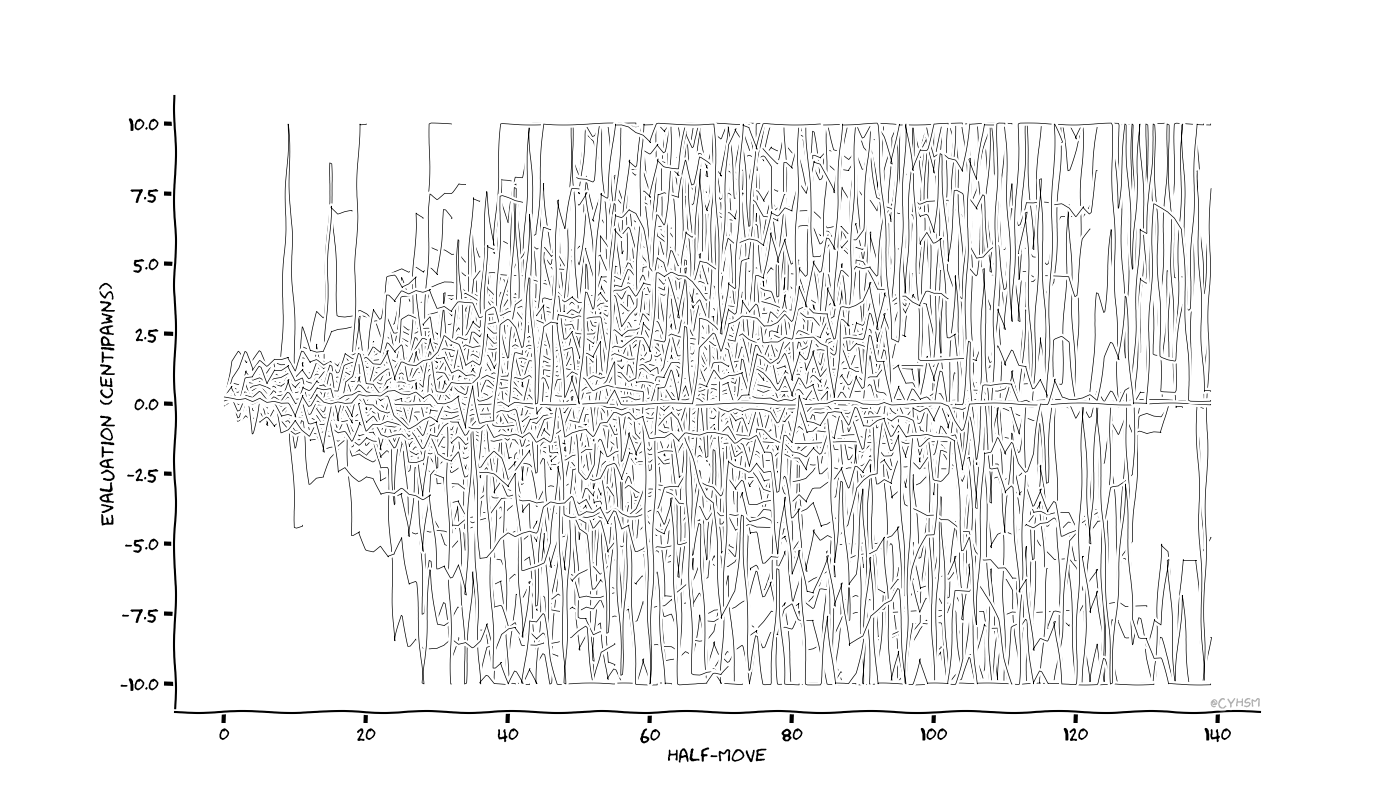

In [16]:
fig, axes = plt.subplots(1,1, figsize=(14, 8))
x = np.arange(0, evaluation_matrix.shape[1])
axes.plot(x, evaluation_matrix.transpose(), 'k', alpha=1, linewidth=0.5)
axes.set_ylabel('Evaluation (centipawns)')
axes.set_xlabel('Half-Move')

fig.text(0.90, 0.115, '@CYHSM',
         fontsize=10, color='gray',
         ha='right', va='bottom', alpha=0.5)

sns.despine()
fig.show()

## Outlier 1

In [6]:
plt.xkcd()

<IPython.core.display.Javascript object>


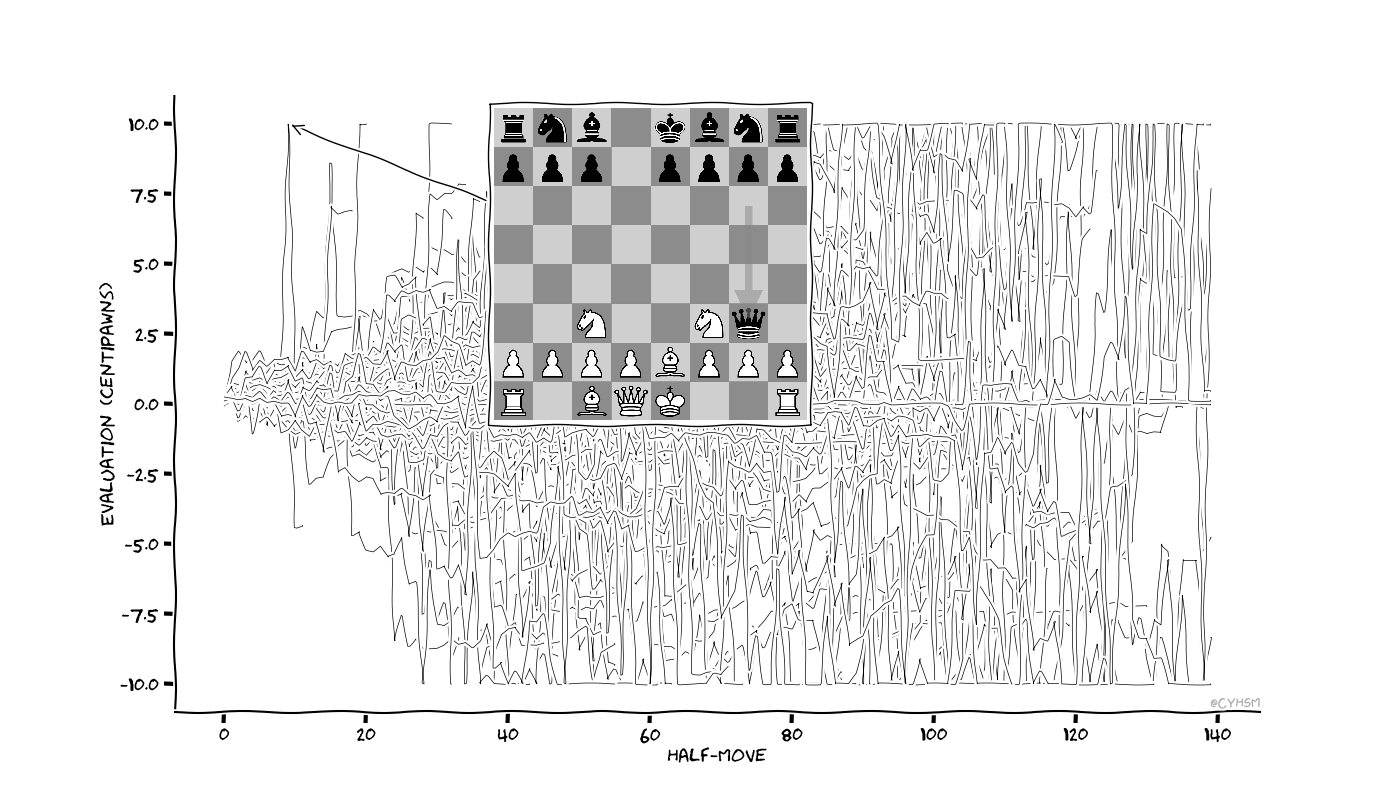

In [7]:
fig, axes = plt.subplots(1,1, figsize=(14, 8))
x = np.arange(0, evaluation_matrix.shape[1])
axes.plot(x, evaluation_matrix.transpose(), 'k', alpha=1, linewidth=0.5)
axes.set_ylabel('Evaluation (centipawns)')
axes.set_xlabel('Half-Move')

fn = get_sample_data("/home/marx/Pictures/cb1_bw.png", asfileobj=False)
arr_img = plt.imread(fn, format='png')

imagebox = OffsetImage(arr_img, zoom=0.25)
imagebox.image.axes = axes

ab = AnnotationBbox(imagebox, (9, 10),
                    xybox=(60, 5),
                    xycoords='data',
                    #boxcoords="offset points",
                    pad=0.25, #bboxprops=dict(edgecolor='b'),
                    arrowprops=dict(arrowstyle="->"))
axes.add_artist(ab)
fig.text(0.90, 0.115, '@CYHSM',
         fontsize=10, color='gray',
         ha='right', va='bottom', alpha=0.5)

sns.despine()
fig.show()

## Outlier 2

<IPython.core.display.Javascript object>


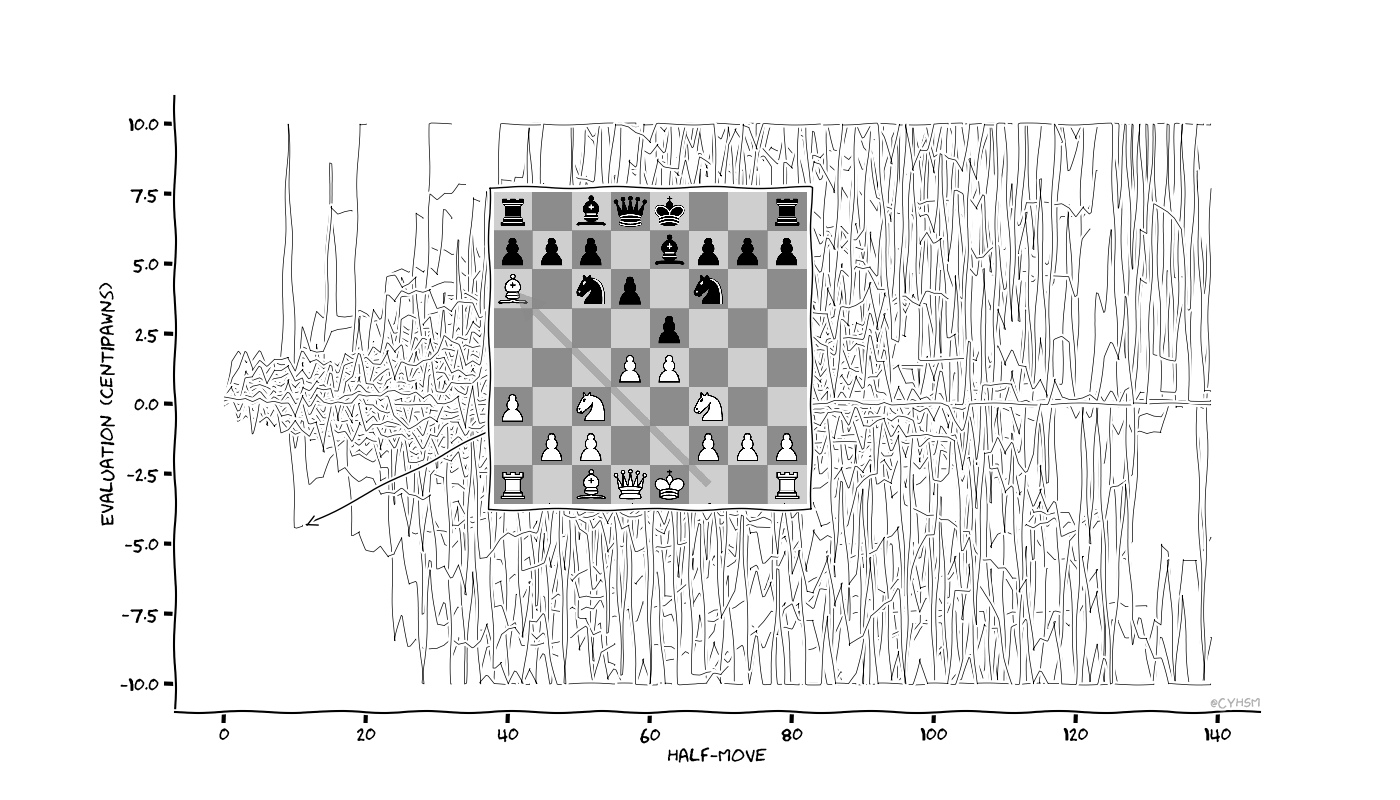

In [8]:
fig, axes = plt.subplots(1,1, figsize=(14, 8))
x = np.arange(0, evaluation_matrix.shape[1])
axes.plot(x, evaluation_matrix.transpose(), 'k', alpha=1, linewidth=0.5)
axes.set_ylabel('Evaluation (centipawns)')
axes.set_xlabel('Half-Move')

fn = get_sample_data("/home/marx/Pictures/cb2_bw.png", asfileobj=False)
arr_img = plt.imread(fn, format='png')
imagebox = OffsetImage(arr_img, zoom=0.25)
imagebox.image.axes = axes
ab = AnnotationBbox(imagebox, (11, -4.4),
                    xybox=(60, 2),
                    xycoords='data',
                    #boxcoords="offset points",
                    pad=0.25, #bboxprops=dict(edgecolor='b'),
                    arrowprops=dict(arrowstyle="->"))
axes.add_artist(ab)
fig.text(0.90, 0.115, '@CYHSM',
         fontsize=10, color='gray',
         ha='right', va='bottom', alpha=0.5)

sns.despine()
fig.show()

## Plot games colored by outcome

In [9]:
alireza = evaluation_matrix[results=='alireza2003', :]
carlsen = evaluation_matrix[results=='DrNykterstein', :]
draw = evaluation_matrix[results=='draw', :]

<IPython.core.display.Javascript object>


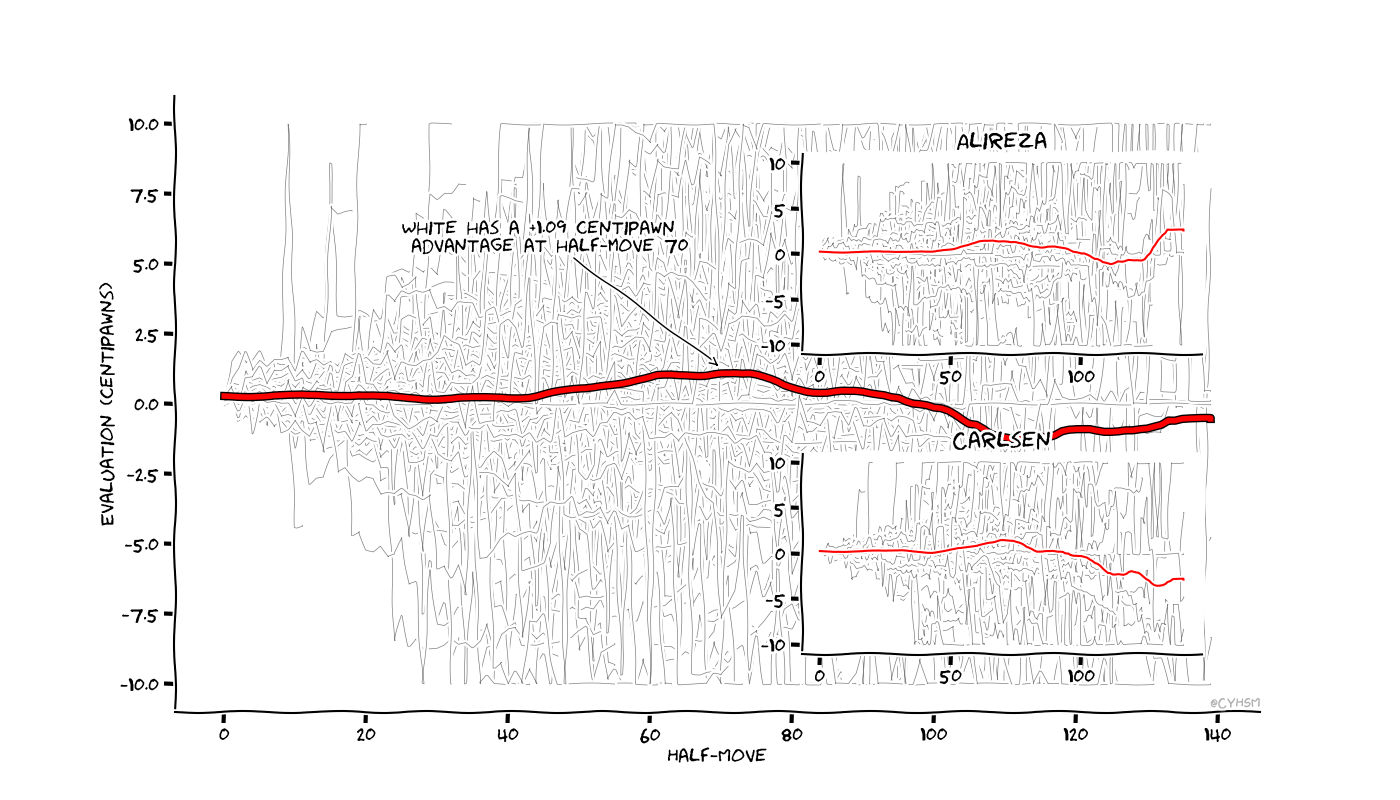

In [10]:
fig, axes = plt.subplots(1,1, figsize=(14, 8))
axcarlsen = inset_axes(axes, width=4, height=2, loc=4, borderpad=3)
axalireza = inset_axes(axes, width=4, height=2, loc=1, borderpad=3)

x = np.arange(0, evaluation_matrix.shape[1])
smooth_avg = smooth_signal(np.nanmean(evaluation_matrix, axis=0), 10)
axes.plot(x, evaluation_matrix.transpose(), 'k', alpha=0.5, linewidth=0.5)
axes.plot(x, smooth_avg, 'r', alpha=0.8, linewidth=1)
axes.plot(x, smooth_avg, 'r', linewidth=4, path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
axes.set_ylabel('Evaluation (centipawns)')
axes.set_xlabel('Half-Move')
axes.annotate('White has a +{:.2f} centipawn \n advantage at half-move {:.0f}'.format(np.max(smooth_avg), np.argmax(smooth_avg)), xy=(np.argmax(smooth_avg), np.max(smooth_avg)+0.2), arrowprops=dict(arrowstyle='->'), xytext=(25, 5.5))

#axcarlsen.plot(x, alireza.transpose(), 'k', alpha=0.25, linewidth=0.5)
#axcarlsen.plot(x, draw.transpose(), 'k', alpha=0.25, linewidth=0.5)
axcarlsen.plot(x, carlsen.transpose(), 'k', alpha=0.5, linewidth=0.5)
axcarlsen.plot(x, smooth_signal(np.nanmean(carlsen, axis=0), 10), 'r', alpha=1, linewidth=1.5)
axcarlsen.set_title('Carlsen')

#axalireza.plot(x, carlsen.transpose(), 'k', alpha=0.25, linewidth=0.5)
#axalireza.plot(x, draw.transpose(), 'k', alpha=0.25, linewidth=0.5)
axalireza.plot(x, alireza.transpose(), 'k', alpha=0.5, linewidth=0.5)
axalireza.plot(x, smooth_signal(np.nanmean(alireza, axis=0), 10), 'r', alpha=1, linewidth=1.5)
axalireza.set_title('Alireza')

fig.text(0.90, 0.115, '@CYHSM',
         fontsize=10, color='gray',
         ha='right', va='bottom', alpha=0.5)
sns.despine()
fig.show()

## Plot games by colored outcome

In [11]:
white = evaluation_matrix[results_color=='white', :]
black = evaluation_matrix[results_color=='black', :]
draw = evaluation_matrix[results_color=='draw', :]

<IPython.core.display.Javascript object>


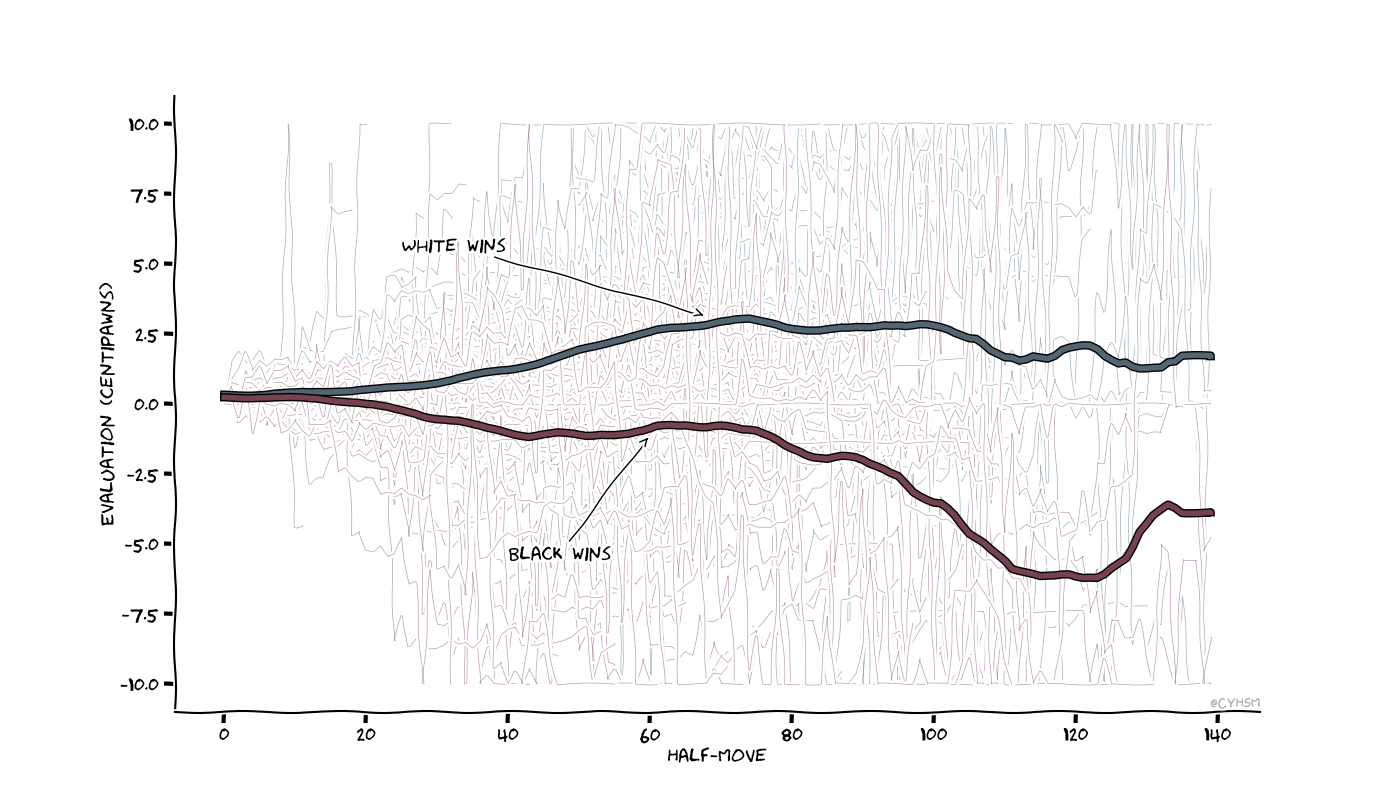

In [12]:
fig, axes = plt.subplots(1,1, figsize=(14, 8))

color1 = '#516572'
color2 = '#76424e'

x = np.arange(0, evaluation_matrix.shape[1])
smooth_white = smooth_signal(np.nanmean(white, axis=0), 10)
smooth_black = smooth_signal(np.nanmean(black, axis=0), 10)

axes.plot(x, white.transpose(), color=color1, alpha=0.5, linewidth=0.5)
axes.plot(x, black.transpose(), color=color2, alpha=0.5, linewidth=0.5)
axes.plot(x, smooth_white, color=color1, alpha=1, linewidth=4, path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
axes.plot(x, smooth_black, color=color2, alpha=1, linewidth=4, path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
axes.set_ylabel('Evaluation (centipawns)')
axes.set_xlabel('Half-Move')
axes.annotate('White wins', xy=(68, np.pi), arrowprops=dict(arrowstyle='->'), xytext=(25, 5.5))
axes.annotate('Black wins', xy=(60, -1.1), arrowprops=dict(arrowstyle='->'), xytext=(40, -5.5))

fig.text(0.90, 0.115, '@CYHSM',
         fontsize=10, color='gray',
         ha='right', va='bottom', alpha=0.5)
sns.despine()
fig.show()

In [13]:
white.shape

(99, 140)

## How about the clock?

/home/marx/.conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/marx/.conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/marx/.conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


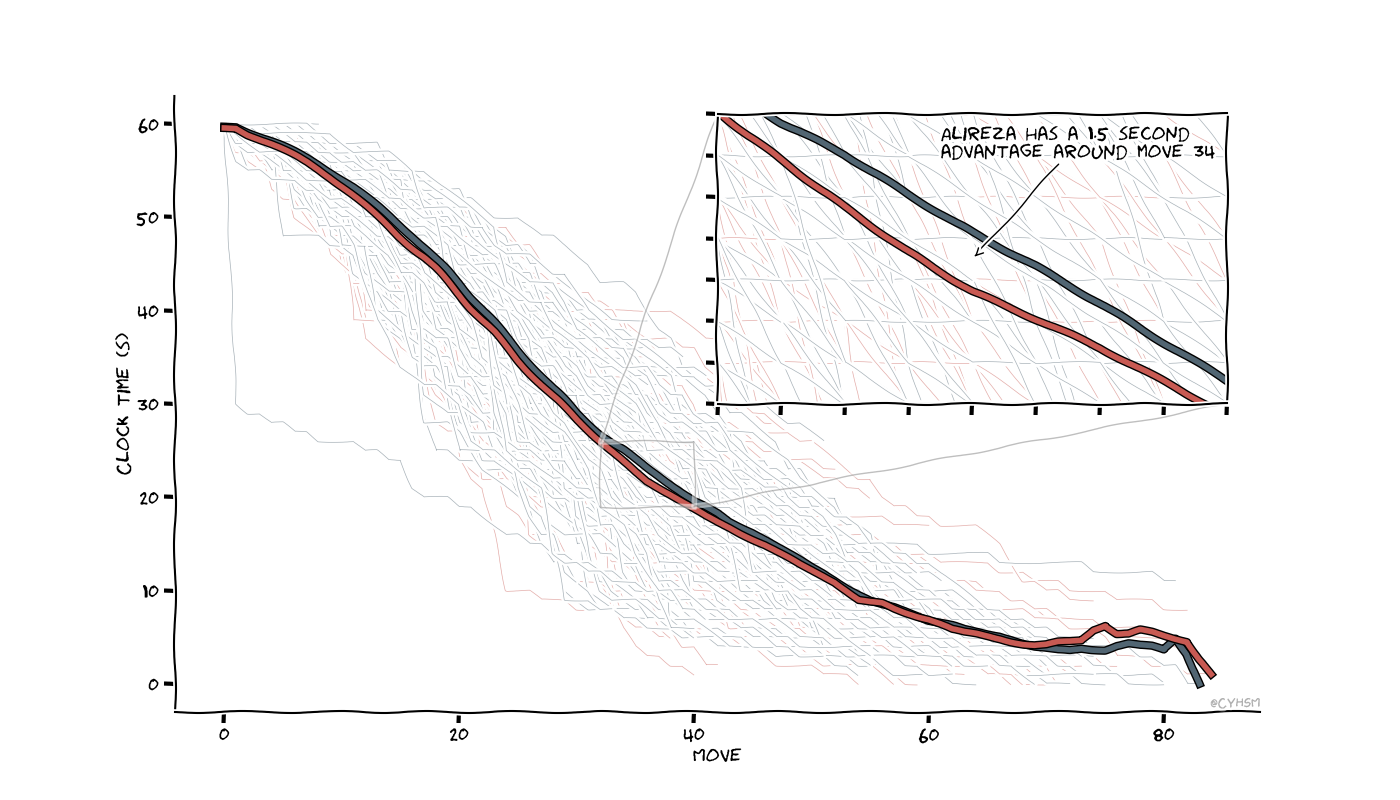

In [14]:
fig, axes = plt.subplots(1,1, figsize=(14, 8))

color1 = '#516572'
color2 = '#c85a53'

x = np.arange(0, clock_matrix_alireza.shape[1])
clock_matrix_diff_mean = np.nanmean(clock_matrix_alireza - clock_matrix_carlsen, axis=0)
smooth_carlsen = smooth_signal(np.nanmean(clock_matrix_carlsen, axis=0), 2)
smooth_alireza = smooth_signal(np.nanmean(clock_matrix_alireza, axis=0), 2)

axes.plot(x, clock_matrix_carlsen.transpose(), color=color2, alpha=0.5, linewidth=0.5)
axes.plot(x, clock_matrix_alireza.transpose(), color=color1, alpha=0.5, linewidth=0.5)
axes.plot(x, smooth_alireza, color=color1, alpha=1, linewidth=4, path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
axes.plot(x, smooth_carlsen, color=color2, alpha=1, linewidth=4, path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])

# inset axes....
axins = axes.inset_axes([0.5, 0.5, 0.47, 0.47])
axins.plot(x, clock_matrix_carlsen.transpose(), color=color2, alpha=0.5, linewidth=0.5)
axins.plot(x, clock_matrix_alireza.transpose(), color=color1, alpha=0.5, linewidth=0.5)
axins.plot(x, smooth_alireza, color=color1, alpha=1, linewidth=4, path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
axins.plot(x, smooth_carlsen, color=color2, alpha=1, linewidth=4, path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
# sub region of the original image
x1, x2, y1, y2 = 32, 40, 19, 26
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axes.indicate_inset_zoom(axins)

axins.annotate('Alireza has a {:.1f} second \nadvantage around move {}'.format(np.max(clock_matrix_diff_mean[0:60]), np.argmax(clock_matrix_diff_mean[0:60])),
              xy=(np.argmax(clock_matrix_diff_mean[0:60])+2, 22.5), arrowprops=dict(arrowstyle='->'), xytext=(35.5, 25))
axes.set_ylabel('Clock time (s)')
axes.set_xlabel('Move')

fig.text(0.90, 0.115, '@CYHSM',
         fontsize=10, color='gray',
         ha='right', va='bottom', alpha=0.5)
sns.despine()
fig.show()

/home/marx/.conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/marx/.conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/home/marx/.conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


<IPython.core.display.Javascript object>


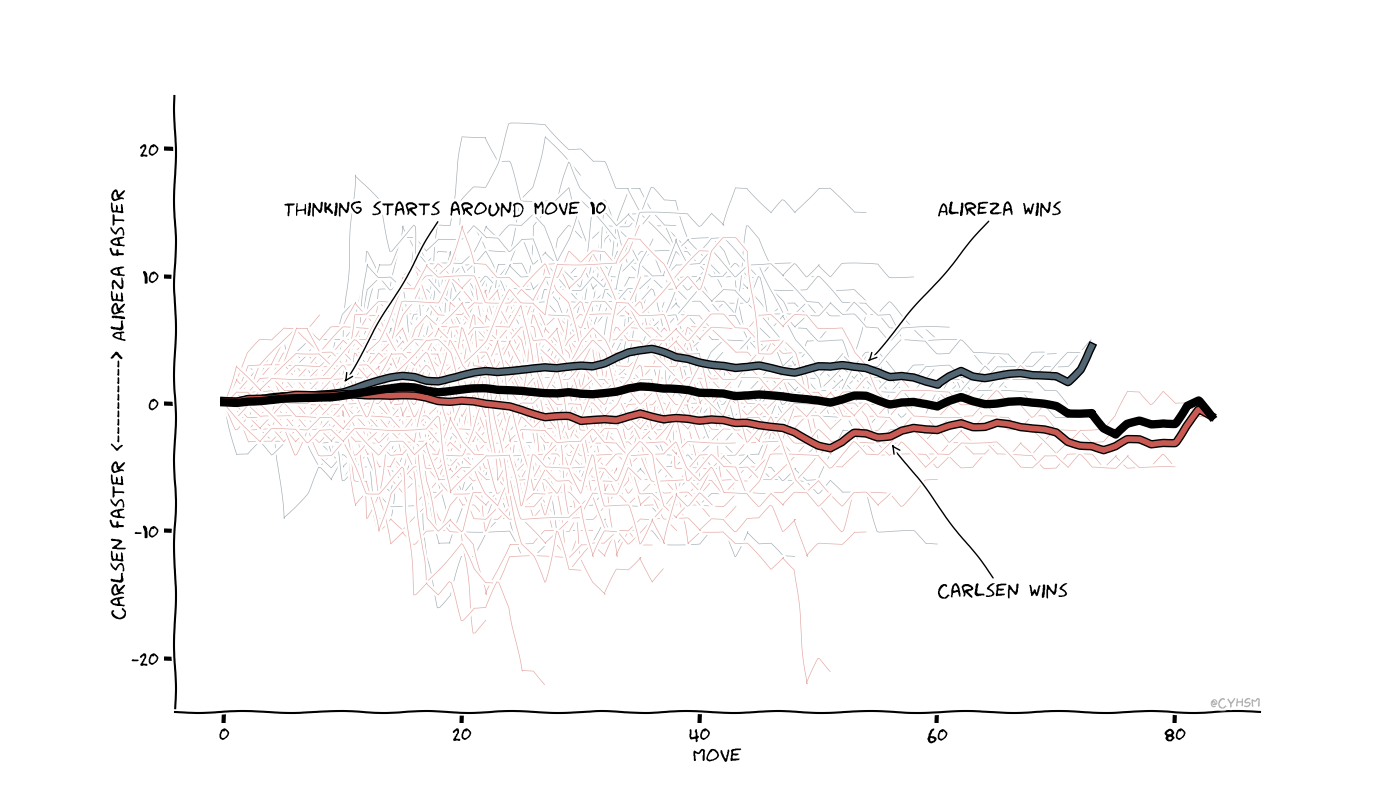

In [15]:
fig, axes = plt.subplots(1,1, figsize=(14, 8))

color1 = '#516572'
color2 = '#c85a53'

clock_matrix_diff = clock_matrix_alireza - clock_matrix_carlsen
carlsen_win = clock_matrix_diff[results=='alireza2003',:]
alireza_win = clock_matrix_diff[results=='DrNykterstein',:]

x = np.arange(0, clock_matrix_diff.shape[1])
smooth_diff = smooth_signal(np.nanmean(clock_matrix_diff, axis=0), 2)
carlsen_win_avg = smooth_signal(np.nanmean(carlsen_win, axis=0), 2)
alireza_win_avg = smooth_signal(np.nanmean(alireza_win, axis=0), 2)

axes.plot(x, carlsen_win.transpose(), color=color1, alpha=0.5, linewidth=0.5)
axes.plot(x, alireza_win.transpose(), color=color2, alpha=0.5, linewidth=0.5)
axes.plot(x, carlsen_win_avg, color=color1, alpha=1, linewidth=4, path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
axes.plot(x, alireza_win_avg, color=color2, alpha=1, linewidth=4, path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
axes.plot(x, smooth_diff, color='k', alpha=1, linewidth=4, path_effects=[pe.Stroke(linewidth=6, foreground='k'), pe.Normal()])
axes.annotate('Alireza wins', xy=(54, np.pi), arrowprops=dict(arrowstyle='->'), xytext=(60, 15))
axes.annotate('Carlsen wins', xy=(56, -3), arrowprops=dict(arrowstyle='->'), xytext=(60, -15))
axes.annotate('Thinking starts around move 10', xy=(10, 1.5), arrowprops=dict(arrowstyle='->'), xytext=(5, 15))
axes.set_ylabel('Carlsen faster <----------> Alireza faster')
axes.set_xlabel('Move')

fig.text(0.90, 0.115, '@CYHSM',
         fontsize=10, color='gray',
         ha='right', va='bottom', alpha=0.5)
sns.despine()
fig.show()